# Anonymeter Diabetes notebook

This notebook demonstrates the usage of `Anonymeter` on Diabetes dataset, a software to derive GDPR-aligned measures of the privacy of synthetic datasets in an empirical, attack based fashion.

`Anonymeter` contains privacy evaluators which measures the risks of singling out, linkability, and inference which might incur to data donors following the release of synthetic dataset. These risk are the three key indicators of factual anonymization according to the European General Data Protection Regulation (GDPR). For more details, please refer to [M. Giomi et al. 2022](https://petsymposium.org/popets/2023/popets-2023-0055.php).

### Basic usage pattern

For each of these privacy risks anonymeter provide an `Evaluator` class. The high-level classes `SinglingOutEvaluator`, `LinkabilityEvaluator`, and `InferenceEvaluator` are the only thing that you need to import from `Anonymeter`.

Despite the different nature of the privacy risks they evaluate, these classes have the same interface and are used in the same way. To instantiate the evaluator you have to provide three dataframes: the original dataset `ori` which has been used to generate the synthetic data, the synthetic data `syn`, and a `control` dataset containing original records which have not been used to generate the synthetic data. 

Another parameter common to all evaluators is the number of target records to attack (`n_attacks`). A higher number will reduce the statistical uncertainties on the results, at the expense of a longer computation time.

```python
evaluator = *Evaluator(ori: pd.DataFrame, 
                       syn: pd.DataFrame, 
                       control: pd.DataFrame,
                       n_attacks: int)
```

Once instantiated the evaluation pipeline is executed when calling the `evaluate`, and the resulting estimate of the risk can be accessed using the `risk()` method.

```python
evaluator.evaluate()
risk = evaluator.risk()
```

### A peak under the hood

In `Anonymeter` each privacy risk is derived from a privacy attacker whose task is to use the synthetic dataset to come up with a set of *guesses* of the form:
- "there is only one person with attributes X, Y, and Z" (singling out)
- "records A and B belong to the same person" (linkability)
- "a person with attributes X and Y also have Z" (inference)

Each evaluation consists of running three different attacks:
- the "main" privacy attack, in which the attacker uses the synthetic data to guess information on records in the original data.
- the "control" privacy attack, in which the attacker uses the synthetic data to guess information on records in the control dataset. 
- the "baseline" attack, which models a naive attacker who ignores the synthetic data and guess randomly.

Checking how many of these guesses are correct, the success rates of the different attacks are measured and used to derive an estimate of the privacy risk. In particular, the "control attack" is used to separate what the attacker learns from the *utility* of the synthetic data, and what is instead indication of privacy leaks. The "baseline attack" instead functions as a sanity check. The "main attack" attack should outperform random guessing in order for the results to be trusted. 

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from anonymeter.evaluators import SinglingOutEvaluator
from anonymeter.evaluators import LinkabilityEvaluator
from anonymeter.evaluators import InferenceEvaluator

## Downloading the data

For this example, we will use the famous `Diabetes` (more details [here](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008)) dataset. For the purpose of demonstrating `Anonymeter`, we will use this data as if each row would in fact refer to a real individual. 

The synthetic version has been generated by `CTGAN` from [SDV](https://sdv.dev/SDV/user_guides/single_table/ctgan.html), as explained in the paper accompanying this code release. For details on the generation process, e.g. regarding hyperparameters, see Section 6.2.1 of [the accompanying paper](https://petsymposium.org/popets/2023/popets-2023-0055.php)).

In [7]:
ori = pd.read_csv("../tests/datasets/diabetes_train.csv")
syn = pd.read_csv("../tests/datasets/diabetes_synthetic.csv")
control = pd.read_csv("../tests/datasets/diabetes_control.csv")

In [10]:
ori.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,citoglipton,insulin,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,Pediatrics-Endocrinology,41,0,1,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,?,59,0,18,No,Up,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,?,11,5,13,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,?,44,1,16,No,Up,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,?,51,0,8,No,Steady,Yes,NO


As visible the dataset contains several demographic information, as well as information regarding the patient_nbr, race, and gender of some tens of thousands of "individuals".

### Measuring the singling out risk

The `SinglingOutEvaluator` try to measure how much the synthetic data can help an attacker finding combination of attributes that single out records in the training data. 

With the following code we evaluate the robustness of the synthetic data to "univariate" singling out attacks, which try to find unique values of some attribute which single out an individual. 


##### NOTE:

The `SingingOutEvaluator` can sometimes raise a `RuntimeError`. This happens when not enough singling out queries are found. Increasing `n_attacks` will make this condition less frequent and the evaluation more robust, although much slower.


In [11]:
evaluator = SinglingOutEvaluator(ori=ori, 
                                 syn=syn, 
                                 control=control,
                                 n_attacks=550)

try:
    evaluator.evaluate(mode='univariate')
    risk = evaluator.risk()
    print(risk)

except RuntimeError as ex: 
    print(f"Singling out evaluation failed with {ex}. Please re-run this cell."
          "For more stable results increase `n_attacks`. Note that this will "
          "make the evaluation slower.")

Found 22 failed queries out of 550. Check DEBUG messages for more details.


PrivacyRisk(value=0.0018118543963158717, ci=(0.0, 0.007875349267171221))


c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\anonymeter\stats\confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.0052735839179794, baseline = 0.01971815081088511. Analysis results cannot be trusted.
  self._sanity_check()


In [12]:
evaluator.queries()[0:3]

['num_lab_procedures == 109']

### Inspecting the results in more details

There are two methods to inspect the results. The high level `risk()` method gives the high level estimation of the privacy risk, and its confidence interval.

In [13]:
evaluator.risk(confidence_level=0.95)

PrivacyRisk(value=0.0018118543963158717, ci=(0.0, 0.007875349267171221))

for more information, the `results()` method gives the success rates of the three attacks (the "main" one, the baseline one, and the one against control) that enters `Anonymeter` risk calculation.

In [14]:
res = evaluator.results()

print("Successs rate of main attack:", res.attack_rate)
print("Successs rate of baseline attack:", res.baseline_rate)
print("Successs rate of control attack:", res.control_rate)

Successs rate of main attack: SuccessRate(value=0.0052735839179794, error=0.0049525580489224895)
Successs rate of baseline attack: SuccessRate(value=0.01971815081088511, error=0.011085762325021365)
Successs rate of control attack: SuccessRate(value=0.0034680130563661863, error=0.003468013056366186)


Note that you can obtain the `PrivacyRisk` from the attack results by:

In [15]:
res.risk()

PrivacyRisk(value=0.0018118543963158717, ci=(0.0, 0.007875349267171221))

### Checking singling out with multivariate predicates

The `SinglingOutEvaluator` can also attack the dataset using predicates which are combining different attributes. These are the so called `multivariate` predicates. 

To run the analysis using the `multivariate` singling out attack, the `mode` parameter of `evaluate` needs to be set correctly. The number of attributes used in the attacker queries via the `n_cols` parameter, set to 4 in this example. 

In [17]:
evaluator = SinglingOutEvaluator(ori=ori, 
                                 syn=syn, 
                                 control=control,
                                 n_attacks=100, # this attack takes longer
                                 n_cols=4)


try:
    evaluator.evaluate(mode='multivariate')
    risk = evaluator.risk()
    print(risk)

except RuntimeError as ex: 
    print(f"Singling out evaluation failed with {ex}. Please re-run this cell."
          "For more stable results increase `n_attacks`. Note that this will "
          "make the evaluation slower.")

Found 24 failed queries out of 100. Check DEBUG messages for more details.


PrivacyRisk(value=0.033007080173236246, ci=(0.0, 0.08162375587268927))


In [18]:
evaluator.queries()[:3]

["discharge_disposition_id>= 17 & admission_source_id>= 16 & medical_specialty== 'Urology' & num_procedures>= 5",
 "discharge_disposition_id<= 1 & race== 'AfricanAmerican' & num_lab_procedures>= 81 & medical_specialty== 'Radiology'",
 "discharge_disposition_id>= 18 & medical_specialty== 'Urology' & age== '[50-60)' & time_in_hospital>= 7"]

# Measuring the Linkability risk

The `LinkabilityEvaluator` allows one to know how much the synthetic data will help an adversary who tries to link two other datasets based on a subset of attributes. 

For example, suppose that the adversary finds dataset A containing, among other fields, information about the profession and education of people, and dataset B containing some demographic and health related information. Can the attacker use the synthetic dataset to link these two datasets?

To run the `LinkabilityEvaluator` one needs to specify which columns of auxiliary information are available to the attacker, and how they are distributed between the two datasets A and B. This is done using the `aux_cols` parameter.

In [19]:
aux_cols = [
    ['encounter_id', 'patient_nbr', 'time_in_hospital', 'num_procedures', 'diabetesMed'],
    [ 'race', 'gender', 'medical_specialty', 'age']
]

evaluator = LinkabilityEvaluator(ori=ori, 
                                 syn=syn, 
                                 control=control,
                                 n_attacks=1000,
                                 aux_cols=aux_cols,
                                 n_neighbors=10)

evaluator.evaluate(n_jobs=-1)  # n_jobs follow joblib convention. -1 = all cores, -2 = all execept one
evaluator.risk()

PrivacyRisk(value=0.002994248858156241, ci=(0.0, 0.007327141416498274))

In [20]:
res = evaluator.results()

print("Successs rate of main attack:", res.attack_rate)
print("Successs rate of baseline attack:", res.baseline_rate)
print("Successs rate of control attack:", res.control_rate)

Successs rate of main attack: SuccessRate(value=0.004901898967320896, error=0.0038811150861822775)
Successs rate of baseline attack: SuccessRate(value=0.002909552484292007, error=0.0027330061136659287)
Successs rate of control attack: SuccessRate(value=0.0019133792427775617, error=0.0019133792427775617)


As visible, the attack is not very successful and the linkability risk is low. The `n_neighbor` parameter can be used to allow for weaker indirect links to be scored as successes. It will have an impact on the risk estimate. To check the measured risk for different values of `n_neighbor` you don't have to re-run the evaluation. Rather, do:

In [21]:
print(evaluator.risk(n_neighbors=7))

PrivacyRisk(value=0.0009980829527187474, ci=(0.0, 0.004339598454051699))


# Measuring the Inference Risk

Finally, `anonymeter` allows to measure the inference risk. It does so by measuring the success of an attacker that tries to discover the value of some secret attribute for a set of target records on which some auxiliary knowledge is available.

Similar to the case of the `LinkabilityEvaluator`, the main parameter here is `aux_cols` which specify what the attacker knows about its target, i.e. which columns are known to the attacker. By selecting the `secret` column, one can identify which attributes, alone or in combinations, exhibit the largest risks and thereby expose a lot of information on the original data.

In the following snippet we will measure the inference risk for each column individually, using all the other columns as auxiliary information to model a very knowledgeable attacker. 

In [22]:
columns = ori.columns
results = []

for secret in columns:
    
    aux_cols = [col for col in columns if col != secret]
    
    evaluator = InferenceEvaluator(ori=ori, 
                                   syn=syn, 
                                   control=control,
                                   aux_cols=aux_cols,
                                   secret=secret,
                                   n_attacks=200)
    evaluator.evaluate(n_jobs=-2)
    results.append((secret, evaluator.results()))

c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\anonymeter\stats\confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.20074782454506632, baseline = 0.22037091801752098. Analysis results cannot be trusted.
  self._sanity_check()
c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\anonymeter\stats\confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.08791503707845197, baseline = 0.13697277075958864. Analysis results cannot be trusted.
  self._sanity_check()
c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\anonymeter\stats\confidence.py:215: UserWarning: Attack is as good or worse as baseline model. Estimated rates: attack = 0.14187854412770232, baseline = 0.19093627780883898. Analysis results cannot be trusted.
  self._sanity_check()
c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\anonymeter\st

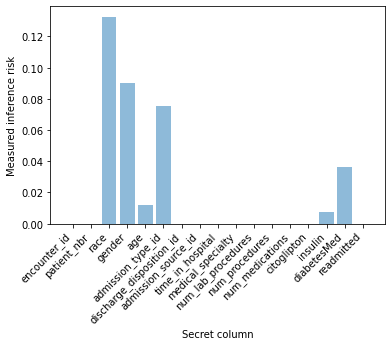

In [23]:
fig, ax = plt.subplots()

risks = [res[1].risk().value for res in results]
columns = [res[0] for res in results]

ax.bar(x=columns, height=risks, alpha=0.5, ecolor='black', capsize=10)

plt.xticks(rotation=45, ha='right')
ax.set_ylabel("Measured inference risk")
_ = ax.set_xlabel("Secret column")

As visible, a few columns in the dataset carry a significant inference risk. This means that an attacker in possession of the synthetic dataset can use it to infer some attribute of records in the original data, *beyond what can be explained by utility*.